In [1]:
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import numpy as np

In [25]:
demand_ids = ['5e27400a-479c-4d84-910a-dbd4754fe1a8', 'c0d0ffa5-7073-416b-ab23-054a6d5cc060', '86aab584-6387-4d48-b53d-d812773089b5', '4b5f8582-f436-45ea-943b-e019287456d1', 'daa6270b-e1aa-4f6d-bf36-c297f908b918']

In [26]:
random_ids = [
    '4c0cb635-d462-4964-9120-0e2ceffe0273', 
    '0695f254-5463-42be-bf32-a592afdc9b81', 
    '7e8cf33a-1c9e-499c-b57d-c1df54e08cef', 
    '669e43b7-b3d1-4d7e-a32c-863a61408a43', 
    'a75a4b91-2bf9-44c8-9b72-c354214429a9'
]

In [27]:
static_ids = ['d383d6cf-549d-42e6-976a-addddc91333d', '6965b6db-870e-4326-abd6-c556e8d065b0', '13878a3a-99cd-48bb-8427-595f628a8b9e', '2c23f9f2-2097-4048-8189-3cab2dd6512c', 'f0794b6c-6203-4275-8e4d-50391ea98d06']

In [28]:
run_dir = "../experiments"

In [29]:
def get_trajectories(sim_ids):
    trajectories = []
    for sim_id in sim_ids:
        df = pd.read_csv(os.path.join(run_dir, sim_id, "output.csv"))
        df['sim-id'] = sim_id
        trajectories.append(df)
    trajectories = pd.concat(trajectories, axis=0)
    trajectories['datetime'] = pd.to_datetime(trajectories['datetime'])
    trajectories['date'] = trajectories['datetime'].dt.date
    
    total_reward = trajectories[['date', 'display', 'revenue', 'sim-id']].groupby(["sim-id","display", "date"]).agg(
    {"revenue": sum}
    )
    total_reward.reset_index(inplace=True)
    mu = total_reward.groupby(['display', 'date']).agg({'revenue': np.mean}).reset_index()
    sig = total_reward.groupby(['display', 'date']).agg({'revenue': np.std}).reset_index()
    
    mu['upper'] = mu['revenue'] + sig['revenue']*1.96
    mu['lower'] = mu['revenue'] - sig['revenue']*1.96
    
    return mu


In [30]:
random_policy = get_trajectories(random_ids)
match_policy = get_trajectories(demand_ids)

FileNotFoundError: [Errno 2] File b'../experiments/4c0cb635-d462-4964-9120-0e2ceffe0273/output.csv' does not exist: b'../experiments/4c0cb635-d462-4964-9120-0e2ceffe0273/output.csv'

In [31]:
static_policy = get_trajectories(static_ids)

FileNotFoundError: [Errno 2] File b'../experiments/d383d6cf-549d-42e6-976a-addddc91333d/output.csv' does not exist: b'../experiments/d383d6cf-549d-42e6-976a-addddc91333d/output.csv'

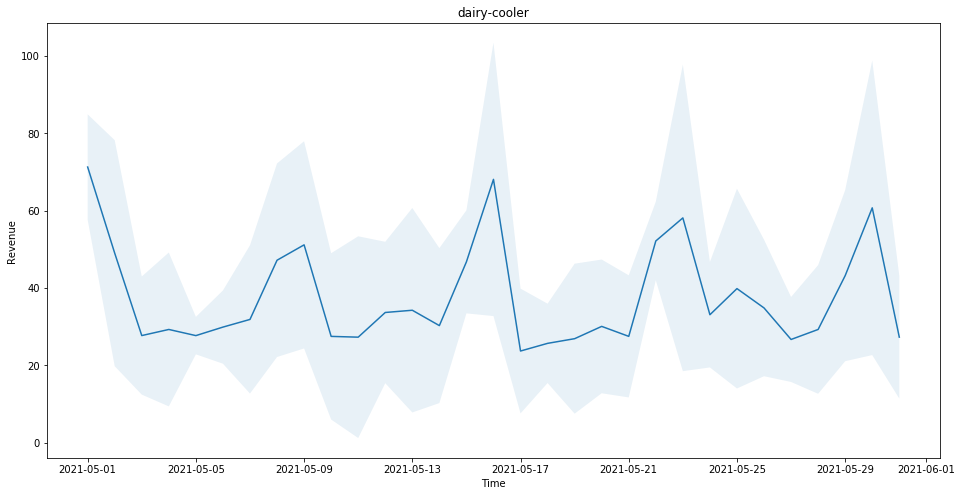

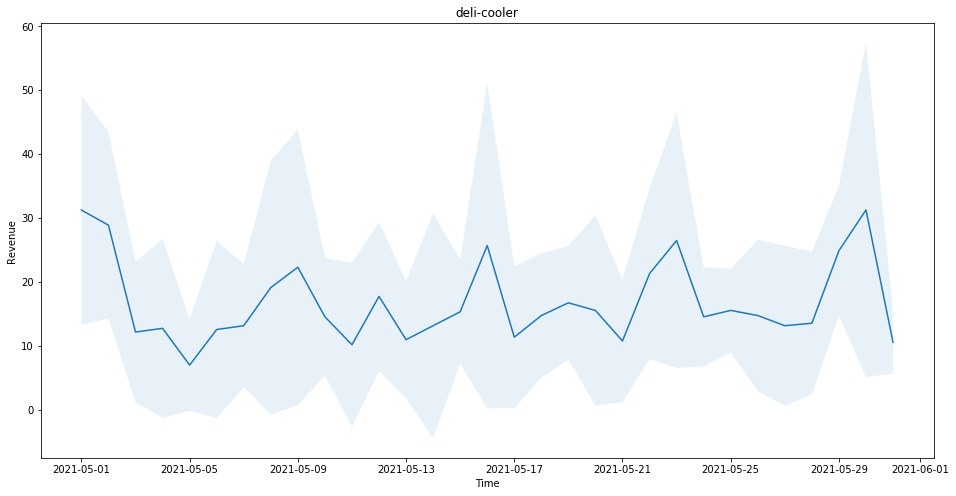

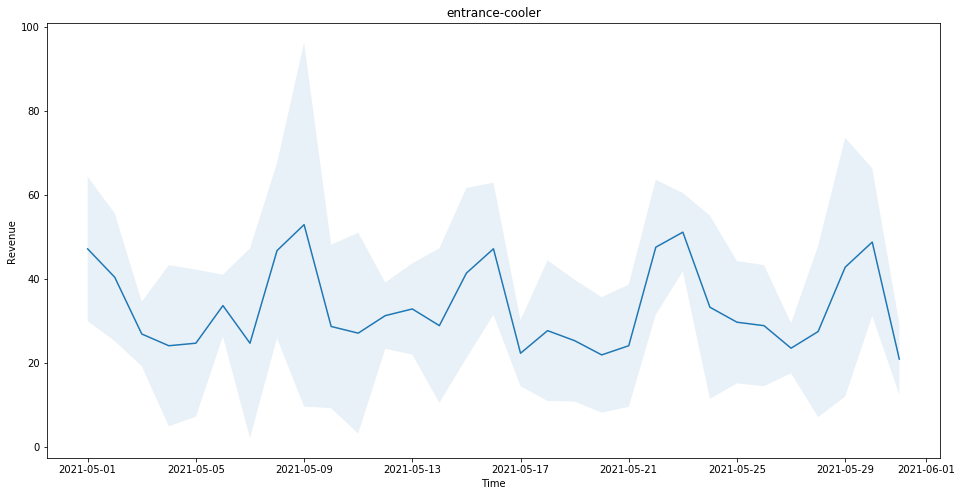

In [32]:
for g, disp_dta  in match_policy.groupby("display"):
    fig = plt.figure(figsize=(16, 8))
    plt.plot(disp_dta["date"], disp_dta["revenue"])
    plt.fill_between(disp_dta["date"],disp_dta["lower"], disp_dta["upper"], alpha=.1)
    plt.title(g)
    plt.xlabel("Time")
    plt.ylabel("Revenue")

In [33]:
display_list = list(random_policy['display'].unique())

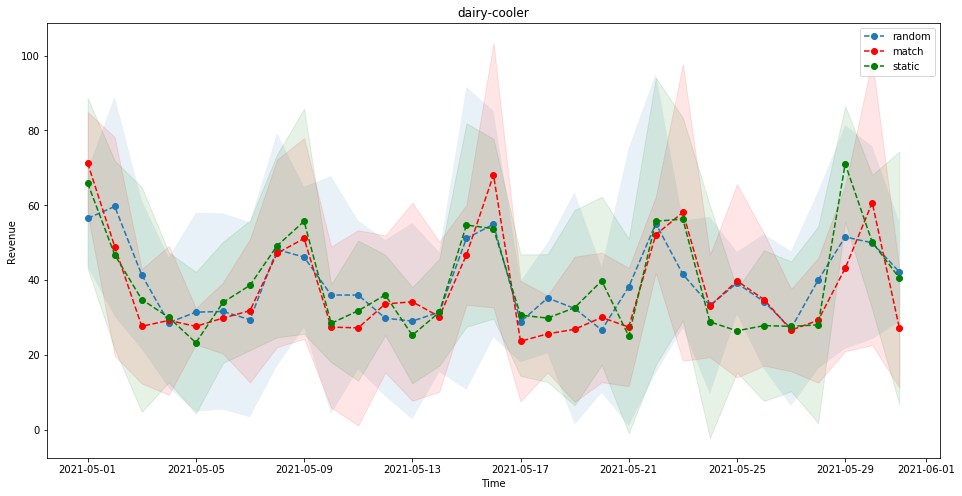

In [ ]:
for d in display_list:
    
    rand_disp = random_policy[random_policy['display'] == d]
    match_disp = match_policy[match_policy['display'] == d]
    static_disp = static_policy[static_policy['display'] ==d]
    
    fig = plt.figure(figsize=(16, 8))
    
    # random
    plt.plot(rand_disp["date"], rand_disp["revenue"], "--", marker='o',  label='random')
    plt.fill_between(rand_disp["date"],rand_disp["lower"], rand_disp["upper"], alpha=.1)
    # match
    plt.plot(match_disp["date"], match_disp["revenue"], "--", marker='o', color='red',  label='match')
    plt.fill_between(match_disp["date"],match_disp["lower"], match_disp["upper"], alpha=.1, color='red')
    # static
    plt.plot(static_disp["date"], static_disp["revenue"], "--", marker='o', color='green',  label='static')
    plt.fill_between(static_disp["date"],static_disp["lower"], static_disp["upper"], alpha=.1, color='green')
    
    
    
    plt.title(d)
    plt.xlabel("Time")
    plt.ylabel("Revenue")
    plt.legend(loc='best')